In [43]:
import warnings
warnings.filterwarnings("ignore")

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.experimental import enable_iterative_imputer 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier

In [46]:
pd.set_option('display.max_columns', None)

# 問題背景說明

所謂癲癇是腦神經細胞的過度放電（=漏電）所引起的臨床表現，而癲癇症的治療方式，一般會以藥物進行治療，約有近八成的癲癇患者可以藉由藥物得到有效的控制，需依照醫師指示定期服用抗癲癇藥物。只要有恆心搭配正確藥物治療，假如數年沒發作，有半數可在減藥後不再發作 （非自行停藥，需經由神經科醫師評估進行），萬一停藥後再發作，只要再度服用藥物幾乎可以百分百控制病情。

在本次的專案中，醫生希望知道有那些特徵的病人更傾向在減藥後復發，進而做到提前預防(ex 增加回診和相關檢查次數)的措施。

我們希望透過減藥前的各種特徵去預測該病人在減藥後的復發機率，進而提供醫生決策的資訊。

- **目標 : 預測病患減藥後的復發機率。**
- **輸入 : 病患的各式特徵。**
- **輸出 : 病患減藥後的機率。**

# Import the data 

In [47]:
df = pd.read_csv("epilepsy.csv")

In [48]:
print(df.shape)

(265, 92)


In [49]:
cols_list = df.columns.tolist()

In [50]:
# Remove probelmatic columns that may cause multicollinearity or causal consideration(timeline) or too many na value and hard to impute
cols_to_remove = ["Unknown",'AED_Last','Focal_Generalized','EEG exam findings\n Normal or Slow= 0 , IIED= 1','Taper_to_Withdraw_Days','Taper_to_Withdraw_Less_6mon','Withdraw_EEG_2Q',
 'Withdraw_EEG_2Q_Result',
 'Withdraw_EEG_2_4Q',
 'Withdraw_EEG_2_4Q_Result',
 'Withdraw_EEG_6Q',
 'Withdraw_EEG_4_6Q_Result',
 'Withdraw_EEG_6_8Q',
 'Withdraw_EEG_6_8Q_Result',
 'Withdraw_EEG_over2Y',
 'Withdraw_EEG_over2Y_Result','Withdraw_to_Recurrence',
 'Withdraw_to_Recurrence_Days','Withdraw_Age',"Recurrence_EEG","Recurrence_EEG_Result","Recurrence_Syndrome","MRI_Findings","MRI_Findings_Sub"]
filtered_cols = [x for x in cols_list if x not in cols_to_remove]

In [51]:
filtered_cols

['Patient_ID',
 'Doctor_ID',
 'Sex',
 'FX',
 'AEDs_Max',
 'AEDs_5year',
 'LEV',
 'LEV_Dosage',
 'OXC',
 'OXC_Dosage',
 'CBZ',
 'CBZ_Dosage',
 'CNZ',
 'CNZ_Dosage',
 'PHT',
 'PHT_Dosage',
 'CLB',
 'CLB_Dosage',
 'VPA',
 'VPA_Dosage',
 'TPM',
 'TPM_Dosage',
 'LMT',
 'LMT_Dosage',
 'ZNS',
 'ZNS_Dosage',
 'PER',
 'PER_Dosage',
 'PBB',
 'PBB_Dosage',
 'GPB',
 'GPB_Dosage',
 'PGB',
 'PGB_Dosage',
 'AEDs_Before_Taper',
 'Eyelid_Clonus',
 'Hospitalized',
 'HX_Disease',
 'Birth',
 'Age',
 'Age_Onset',
 'Onset_Young18',
 'Year_Onset_to_Taper',
 'Etiology',
 'Etiology_1',
 'Etiology_Unknown',
 'Presumed_epileptic_focus',
 'Presumed_epileptic_focus_noLR',
 'Generalized',
 'MRI_Abnormal',
 'MRI_Abnormal_Epilepsy',
 'Last_Attack',
 'Reduce_Medication',
 'Brain_Wave_Date_Before_Taper',
 'EEG_Before_Taper',
 'EEG_Result',
 'Treatment_Start',
 'Treatment_to_Taper_Days',
 'Taper_Start',
 'Withdraw_Start',
 'Taper_Age',
 'Last_Visit',
 'Treatment_to_Taper_Less2Y',
 'Reccurence_Type',
 'Recurrence',
 'Rec

In [52]:
df = df[filtered_cols]

In [53]:
df.shape

(265, 68)

# Data Cleaning

### Missing Value

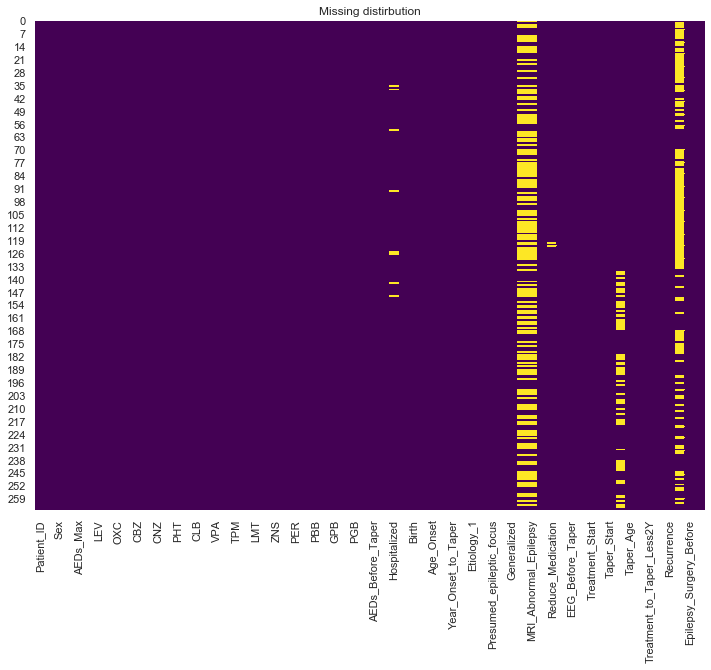

Columns with missing values:
Hospitalized
MRI_Abnormal
MRI_Abnormal_Epilepsy
Reduce_Medication
Withdraw_Start
Recurrence_Date


In [54]:
# First check the missing value
plt.figure(figsize=(12, 9))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing distirbution')
plt.show()
columns_with_missing_values = df.columns[df.isnull().any()]
print("Columns with missing values:")
for column in columns_with_missing_values:
    print(column)

- Missing in "Hospitalized" column indicates patient is hospitalized <span>&#8594;</span> <b>Data imputation by fact</b>
- "MRI_Abnormal" and "MRI_Abnormal_Epilepsy" have a lot of missing <span>&#8594;</span> <b>Impute by model after setting datatype</b>
- "Reduce_Medication" has 2 missing values <span>&#8594;</span> <b>Impute by mode "By_doctor"</b>
- Missing in "Recurrenc Date"  means no recurrence can be <b>seen as Censored</b>

In [55]:
# Hospitalized
df['Hospitalized'].fillna(1, inplace = True)
# Reduce_Medication
df['Reduce_Medication'].fillna("By_doctor", inplace = True)
# MRI
#rem_cols = ["MRI_Abnormal" , "MRI_Abnormal_Epilepsy" ]
#df.drop(columns= rem_cols, inplace = True)

In [56]:
columns_with_missing_values = df.columns[df.isnull().any()]
print("Columns with missing values:")
for column in columns_with_missing_values:
    print(column)

Columns with missing values:
MRI_Abnormal
MRI_Abnormal_Epilepsy
Withdraw_Start
Recurrence_Date


## Setting datatype

In [57]:
df.HX_Disease

0                 None
1      G6PD deficiency
2           concussion
3                 None
4                 None
            ...       
260               None
261               None
262               None
263               None
264         Brain DNET
Name: HX_Disease, Length: 265, dtype: object

In [58]:
# Take a look at the data
df.describe(include = 'all')

,Patient_ID,Doctor_ID,Sex,FX,AEDs_Max,AEDs_5year,LEV,LEV_Dosage,OXC,OXC_Dosage,CBZ,CBZ_Dosage,CNZ,CNZ_Dosage,PHT,PHT_Dosage,CLB,CLB_Dosage,VPA,VPA_Dosage,TPM,TPM_Dosage,LMT,LMT_Dosage,ZNS,ZNS_Dosage,PER,PER_Dosage,PBB,PBB_Dosage,GPB,GPB_Dosage,PGB,PGB_Dosage,AEDs_Before_Taper,Eyelid_Clonus,Hospitalized,HX_Disease,Birth,Age,Age_Onset,Onset_Young18,Year_Onset_to_Taper,Etiology,Etiology_1,Etiology_Unknown,Presumed_epileptic_focus,Presumed_epileptic_focus_noLR,Generalized,MRI_Abnormal,MRI_Abnormal_Epilepsy,Last_Attack,Reduce_Medication,Brain_Wave_Date_Before_Taper,EEG_Before_Taper,EEG_Result,Treatment_Start,Treatment_to_Taper_Days,Taper_Start,Withdraw_Start,Taper_Age,Last_Visit,Treatment_to_Taper_Less2Y,Reccurence_Type,Recurrence,Recurrence_Date,Epilepsy_Surgery_Before,Faile_Taper_Before
count,2.650000e+02,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265,265,265.000000,265.000000,265.000000,265.00000,265,265,265.000000,265,265,265.000000,121.000000,121.000000,265,265,265,265,265,265,265.000000,265,209,265.000000,265,265.000000,265,265.000000,115,265.000000,265.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14,260,NaN,NaN,NaN,NaN,5,38,NaN,31,14,NaN,NaN,NaN,250,2,251,3,3,244,NaN,241,196,NaN,195,NaN,3,NaN,108,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,1989/7/10,NaN,NaN,NaN,NaN,Unknown,Cryptogenic,NaN,FLE,TLE,NaN,NaN,NaN,2014/2/26,By_doctor,2016/11/1,Three_Hours,Normal,2000/7/12,NaN,2019/5/8,2015/8/5,NaN,2023/8/30,NaN,No_Reccur,NaN,2019/3/13,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,250,2,NaN,NaN,NaN,NaN,132,127,NaN,39,73,NaN,NaN,NaN,3,251,3,194,219,4,NaN,4,3,NaN,13,NaN,150,NaN,3,NaN,NaN
mean,1.500703e+07,1994.150943,1.464151,0.105660,1.426415,1.396226,0.358491,294.905660,0.132075,78.113208,0.109434,58.867925,0.113208,0.107547,0.116981,33.773585,0.007547,0.113208,0.252830,193.207547,0.116981,14.716981,0.071698,8.339623,0.007547,1.886792,0.003774,0.007547,0.003774,0.792453,0.011321,9.433962,0.003774,1.132075,1.309434,0.015094,0.033962,NaN,NaN,46.773585,27.256604,0.403774,11.65283,NaN,NaN,0.501887,NaN,NaN,0.241509,0.520661,0.462810,NaN,NaN,NaN,NaN,NaN,NaN,2483.192453,NaN,NaN,38.909434,NaN,0.109434,NaN,0.433962,NaN,0.011321,0.086792
std,1.359290e+07,2499.991758,0.499657,0.307984,0.653705,0.637812,0.480465,457.370708,0.339213,219.659314,0.312774,188.712347,0.317446,0.387713,0.322006,94.552904,0.086710,1.371523,0.435457,389.554785,0.322006,51.863157,0.258476,36.807723,0.086710,22.109970,0.061430,0.122859,0.061430,12.900197,0.105995,106.358725,0.061430,18.428854,0.592332,0.122159,0.181475,NaN,NaN,15.356424,16.492715,0.491582,10.26838,NaN,NaN,0.500943,NaN,NaN,0.428808,0.501650,0.500688,NaN,NaN,NaN,NaN,NaN,NaN,1730.655611,NaN,NaN,15.685815,NaN,0.312774,NaN,0.496558,NaN,0.105995,0.282063
min,2.386900e+05,599.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,NaN,NaN,18.000000,1.000000,0.000000,0.00000,NaN,NaN,0.000000,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,35.000000,NaN,NaN,9.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,0.000000
25%,3.724319e+06,599.000000,1.00000

-  'Patient_ID' and 'Doctor_ID' set to str datatype
- 'Sex' need to change to Male/Female
- 'HX_Disease' can be turned into binary column
-  'Birth' can be removed
-  Create a Last_Attack to Taper day, set 'Last_Attack' to date
-  Set 'Brain_Wave_Date_Before_Taper' to date and create Brain_Wave to taper day
-  Set 'Treatment_Start' to date
-  Set 'Taper_Start' to date
-  Set 'Withdraw_Start' to date
-  Set 'Last_Visit' to date
-  Set 'Recurrence_Date' to date

In [59]:
# Sex
replace_dict = {1:'Female',2:'Male'}
df['Sex'] = df['Sex'].replace(replace_dict)
# HX_Disease
df['HX_Disease'] = df['HX_Disease'].apply(lambda x : 0 if x == 'None' else 1)
# Birth
df.drop(columns = 'Birth', inplace = True)
# Set date datatype
column_data_types = {
    'Patient_ID': 'str',
    'Doctor_ID': 'str',
    'Last_Attack':'datetime64',
    'Brain_Wave_Date_Before_Taper' :'datetime64',
    'Treatment_Start':'datetime64',
    'Taper_Start':'datetime64',
    'Withdraw_Start' :'datetime64',
    'Last_Visit' :'datetime64',
    'Recurrence_Date':'datetime64'
}
df = df.astype(column_data_types)

### Feature Engineering
- Create "Last_Attack_to_Taper_day"
- Create "BrainWave_to_Taper_day"

In [60]:
df["Last_Attack_to_Taper_day"] = (df["Taper_Start"]-df["Last_Attack"]).dt.days
df["BrainWave_to_Taper_day"] = (df["Taper_Start"]-df["Brain_Wave_Date_Before_Taper"]).dt.days

In [61]:
print(sum(df["Last_Attack_to_Taper_day"]<0))
print(sum(df["BrainWave_to_Taper_day"]<0))

2
18


In [62]:
df["Last_Attack_to_Taper_day"] = df["Last_Attack_to_Taper_day"].apply(lambda x : 0 if x < 0 else x)
df["BrainWave_to_Taper_day"] = df["BrainWave_to_Taper_day"].apply(lambda x : 0 if x < 0 else x)

In [63]:
print(sum(df["Last_Attack_to_Taper_day"]<0))
print(sum(df["BrainWave_to_Taper_day"]<0))

0
0


### One hot encoding categorical variable

In [64]:
df.describe(include = "object")

,Patient_ID,Doctor_ID,Sex,Etiology,Etiology_1,Presumed_epileptic_focus,Presumed_epileptic_focus_noLR,Reduce_Medication,EEG_Before_Taper,EEG_Result,Reccurence_Type
count,265,265,265,265,265,265,265,265,265,265,265
unique,263,10,2,5,38,31,14,2,3,3,3
top,20851743,599,Female,Unknown,Cryptogenic,FLE,TLE,By_doctor,Three_Hours,Normal,No_Reccur
freq,2,195,142,132,127,39,73,251,194,219,150


In [65]:
df.drop(columns = ["Patient_ID","Doctor_ID"], inplace = True)
object_columns = df.select_dtypes(include = "object").columns
df_encoded = pd.get_dummies(df, columns = object_columns)

In [66]:
df.describe()

,FX,AEDs_Max,AEDs_5year,LEV,LEV_Dosage,OXC,OXC_Dosage,CBZ,CBZ_Dosage,CNZ,CNZ_Dosage,PHT,PHT_Dosage,CLB,CLB_Dosage,VPA,VPA_Dosage,TPM,TPM_Dosage,LMT,LMT_Dosage,ZNS,ZNS_Dosage,PER,PER_Dosage,PBB,PBB_Dosage,GPB,GPB_Dosage,PGB,PGB_Dosage,AEDs_Before_Taper,Eyelid_Clonus,Hospitalized,HX_Disease,Age,Age_Onset,Onset_Young18,Year_Onset_to_Taper,Etiology_Unknown,Generalized,MRI_Abnormal,MRI_Abnormal_Epilepsy,Treatment_to_Taper_Days,Taper_Age,Treatment_to_Taper_Less2Y,Recurrence,Epilepsy_Surgery_Before,Faile_Taper_Before,Last_Attack_to_Taper_day,BrainWave_to_Taper_day
count,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.00000,265.000000,265.000000,121.000000,121.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000
mean,0.105660,1.426415,1.396226,0.358491,294.905660,0.132075,78.113208,0.109434,58.867925,0.113208,0.107547,0.116981,33.773585,0.007547,0.113208,0.252830,193.207547,0.116981,14.716981,0.071698,8.339623,0.007547,1.886792,0.003774,0.007547,0.003774,0.792453,0.011321,9.433962,0.003774,1.132075,1.309434,0.015094,0.033962,0.056604,46.773585,27.256604,0.403774,11.65283,0.501887,0.241509,0.520661,0.462810,2483.192453,38.909434,0.109434,0.433962,0.011321,0.086792,1377.709434,188.411321
std,0.307984,0.653705,0.637812,0.480465,457.370708,0.339213,219.659314,0.312774,188.712347,0.317446,0.387713,0.322006,94.552904,0.086710,1.371523,0.435457,389.554785,0.322006,51.863157,0.258476,36.807723,0.086710,22.109970,0.061430,0.122859,0.061430,12.900197,0.105995,106.358725,0.061430,18.428854,0.592332,0.122159,0.181475,0.231521,15.356424,16.492715,0.491582,10.26838,0.500943,0.428808,0.501650,0.500688,1730.655611,15.685815,0.312774,0.496558,0.105995,0.282063,950.355318,441.968454
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,18.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,35.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,34.000000,15.000000,0.000000,4.00000,0.000000,0.000000,0.000000,0.000000,1100.000000,27.000000,0.000000,0.000000,0.000000,0.000000,882.000000,12.000000
50%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,44.000000,21.000000,0.000000,8.00000,1.000000,0.000000,1.000000,0.000000,1885.000000,37.000000,0.000000,0.000000,0.000000,0.000000,1190.000000,44.000000
75%,0.000000,2.000000,2.000000,1.000000,500.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,200.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,58.000000,37.000000,1.000000,17.00000,1.000000,0.000000,1.000000,1.000000,3841.000000,49.000000,0.000000,1.000000,0.000000,0.000000,1608.000000,88.000000
max,1.000000,4

### Build prediction model for MRI missing data(can be improved)

In [67]:
columns_with_missing_values = df_encoded.columns[df_encoded.isnull().any()]
print("Columns with missing values:")
for column in columns_with_missing_values:
    print(column)

Columns with missing values:
MRI_Abnormal
MRI_Abnormal_Epilepsy
Withdraw_Start
Recurrence_Date


In [68]:
features = df_encoded.dropna(axis =1).columns.to_list()
datetime_columns = df.select_dtypes(include='datetime64').columns.to_list()
features_2 = [x for x in features if x not in datetime_columns]
# Split the data into two parts: one with missing values in column 'MRI_Abnoraml' and one without
df_missing = df_encoded[df_encoded['MRI_Abnormal'].isnull()]
df_not_missing = df_encoded.dropna(subset=['MRI_Abnormal'])

# Select features and target 
X = df_not_missing[features_2]
y = df_not_missing['MRI_Abnormal']

# Train a Random Forest Regressor
rf_model = RandomForestRegressor()
rf_model.fit(X, y)

# Use the trained model to predict missing values in column 'MRI_Abnormal'
X_missing = df_missing[features_2]
predicted_values = rf_model.predict(X_missing)

# Impute the predicted values into column "A"
df_encoded.loc[df_encoded['MRI_Abnormal'].isnull(), 'MRI_Abnormal'] = predicted_values



In [69]:
features = df_encoded.dropna(axis =1).columns.to_list()
datetime_columns = df.select_dtypes(include='datetime64').columns.to_list()
features_2 = [x for x in features if x not in datetime_columns]
# Split the data into two parts: one with missing values in column 'MRI_Abnoraml' and one without
df_missing = df_encoded[df_encoded['MRI_Abnormal_Epilepsy'].isnull()]
df_not_missing = df_encoded.dropna(subset=['MRI_Abnormal_Epilepsy'])

# Select features and target 
X = df_not_missing[features_2]
y = df_not_missing['MRI_Abnormal_Epilepsy']

# Train a Random Forest Regressor
rf_model = RandomForestRegressor()
rf_model.fit(X, y)

# Use the trained model to predict missing values in column 'MRI_Abnormal'
X_missing = df_missing[features_2]
predicted_values = rf_model.predict(X_missing)

# Impute the predicted values into column "A"
df_encoded.loc[df_encoded['MRI_Abnormal_Epilepsy'].isnull(), 'MRI_Abnormal_Epilepsy'] = predicted_values


In [70]:
columns_with_missing_values = df_encoded.columns[df_encoded.isnull().any()]
print("Columns with missing values:")
for column in columns_with_missing_values:
    print(column)

Columns with missing values:
Withdraw_Start
Recurrence_Date


### Scale the days to years 

In [71]:
df_encoded.columns.to_list()

['FX',
 'AEDs_Max',
 'AEDs_5year',
 'LEV',
 'LEV_Dosage',
 'OXC',
 'OXC_Dosage',
 'CBZ',
 'CBZ_Dosage',
 'CNZ',
 'CNZ_Dosage',
 'PHT',
 'PHT_Dosage',
 'CLB',
 'CLB_Dosage',
 'VPA',
 'VPA_Dosage',
 'TPM',
 'TPM_Dosage',
 'LMT',
 'LMT_Dosage',
 'ZNS',
 'ZNS_Dosage',
 'PER',
 'PER_Dosage',
 'PBB',
 'PBB_Dosage',
 'GPB',
 'GPB_Dosage',
 'PGB',
 'PGB_Dosage',
 'AEDs_Before_Taper',
 'Eyelid_Clonus',
 'Hospitalized',
 'HX_Disease',
 'Age',
 'Age_Onset',
 'Onset_Young18',
 'Year_Onset_to_Taper',
 'Etiology_Unknown',
 'Generalized',
 'MRI_Abnormal',
 'MRI_Abnormal_Epilepsy',
 'Last_Attack',
 'Brain_Wave_Date_Before_Taper',
 'Treatment_Start',
 'Treatment_to_Taper_Days',
 'Taper_Start',
 'Withdraw_Start',
 'Taper_Age',
 'Last_Visit',
 'Treatment_to_Taper_Less2Y',
 'Recurrence',
 'Recurrence_Date',
 'Epilepsy_Surgery_Before',
 'Faile_Taper_Before',
 'Last_Attack_to_Taper_day',
 'BrainWave_to_Taper_day',
 'Sex_Female',
 'Sex_Male',
 'Etiology_Genetic',
 'Etiology_Immune',
 'Etiology_Infections',
 

In [72]:
# Scale the days to years and do the same thing again
def days_to_years(column):
    return column/365
columns_to_apply = ['BrainWave_to_Taper_day','Last_Attack_to_Taper_day',"Treatment_to_Taper_Days"]
df_encoded[columns_to_apply] = df_encoded[columns_to_apply].apply(days_to_years)

# Descriptive Statistic of Response Variable

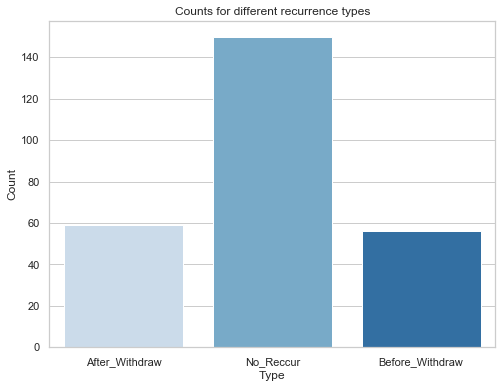

In [73]:
sns.set(style="whitegrid")

# Bar chart
plt.figure(figsize=(8, 6))
sns.countplot(x='Reccurence_Type', data=df, palette='Blues')
plt.title('Counts for different recurrence types')
plt.xlabel('Type')
plt.ylabel('Count')
plt.show()

In [74]:
df['Reccurence_Type'] = df['Reccurence_Type'].replace({'Before_Withdraw': 'Reccur_Due_to_Taper',
                                                       'After_Withdraw': 'Not_Reccur_Due_to_Taper',
                                                      'No_Reccur': 'Not_Reccur_Due_to_Taper'})

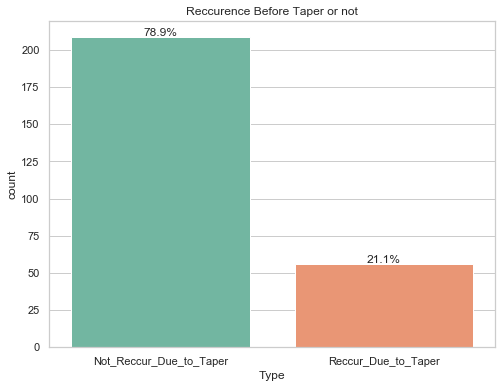

In [75]:
sns.set(style="whitegrid")

# Count plot
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='Reccurence_Type', data=df, palette='Set2')
plt.title('Reccurence Before Taper or not')
plt.xlabel('Type')
plt.ylabel('count')

# Add percentage
total = len(df['Reccurence_Type'])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height + 0.5, f'{height/total:.1%}', ha="center")

plt.show()

---

# Build Logistic Regression

In [76]:
y = df['Reccurence_Type'].replace({"Not_Reccur_Due_to_Taper":0,"Reccur_Due_to_Taper":1})

In [77]:
columns_remove = ['Withdraw_Start','Recurrence','Recurrence_Date','Reccurence_Type_After_Withdraw',
 'Reccurence_Type_Before_Withdraw','Reccurence_Type_No_Reccur']
columns_remove+= datetime_columns
X = df_encoded.drop(columns = columns_remove)

In [78]:
X.head()

,FX,AEDs_Max,AEDs_5year,LEV,LEV_Dosage,OXC,OXC_Dosage,CBZ,CBZ_Dosage,CNZ,CNZ_Dosage,PHT,PHT_Dosage,CLB,CLB_Dosage,VPA,VPA_Dosage,TPM,TPM_Dosage,LMT,LMT_Dosage,ZNS,ZNS_Dosage,PER,PER_Dosage,PBB,PBB_Dosage,GPB,GPB_Dosage,PGB,PGB_Dosage,AEDs_Before_Taper,Eyelid_Clonus,Hospitalized,HX_Disease,Age,Age_Onset,Onset_Young18,Year_Onset_to_Taper,Etiology_Unknown,Generalized,MRI_Abnormal,MRI_Abnormal_Epilepsy,Treatment_to_Taper_Days,Taper_Age,Treatment_to_Taper_Less2Y,Epilepsy_Surgery_Before,Faile_Taper_Before,Last_Attack_to_Taper_day,BrainWave_to_Taper_day,Sex_Female,Sex_Male,Etiology_Genetic,Etiology_Immune,Etiology_Infections,Etiology_Structural,Etiology_Unknown,Etiology_1_AVM,Etiology_1_Autism,Etiology_1_Brain DNET,Etiology_1_Brain Tumor,Etiology_1_Brain abscess,Etiology_1_Brain avscess,Etiology_1_Brain hemorrhage,Etiology_1_CNS infection,Etiology_1_Cryptogenic,Etiology_1_Cryptogenic(MJ),Etiology_1_Encephalitis,Etiology_1_Head injury,Etiology_1_Hemiatrophy,Etiology_1_IGE GTCS,Etiology_1_Idiopathic,Etiology_1_JAE,Etiology_1_JME,Etiology_1_Meningitis,Etiology_1_NF1,Etiology_1_Stroke,Etiology_1_Vascular anomaly,Etiology_1_abscess,Etiology_1_alcohol withdraw,Etiology_1_aneurym,Etiology_1_birth injury,Etiology_1_brain dysmorphic,Etiology_1_brain lesion,Etiology_1_cavernoma,Etiology_1_cystic lesion,Etiology_1_drug induce,Etiology_1_encephalitis,Etiology_1_head injury,Etiology_1_idiopathic,Etiology_1_infarction,Etiology_1_kernicterus,Etiology_1_meningioma,Etiology_1_tumor,Etiology_1_unknown,Presumed_epileptic_focus_Bil FLE,Presumed_epileptic_focus_Bil hemisphere,Presumed_epileptic_focus_F-T,Presumed_epileptic_focus_FLE,Presumed_epileptic_focus_Generalized,Presumed_epileptic_focus_IGE GTCS,Presumed_epileptic_focus_JAE,Presumed_epileptic_focus_JME,Presumed_epileptic_focus_JME(rolandic?),Presumed_epileptic_focus_L't F-T,Presumed_epileptic_focus_L't FLE,Presumed_epileptic_focus_L't FLE(rolandic),Presumed_epileptic_focus_L't MTLE,Presumed_epileptic_focus_L't TLE,Presumed_epileptic_focus_L't hemisphere,Presumed_epileptic_focus_MTLE,Presumed_epileptic_focus_NFLE,Presumed_epileptic_focus_OLE,Presumed_epileptic_focus_PLE,Presumed_epileptic_focus_Primary Generalized,Presumed_epileptic_focus_R't F-T,Presumed_epileptic_focus_R't FLE,Presumed_epileptic_focus_R't OLE,Presumed_epileptic_focus_R't PLE,Presumed_epileptic_focus_R't TLE,Presumed_epileptic_focus_R't hemisphere,Presumed_epileptic_focus_Right T-O,Presumed_epileptic_focus_Right TLE,Presumed_epileptic_focus_T-O,Presumed_epileptic_focus_TLE,Presumed_epileptic_focus_unknown,Presumed_epileptic_focus_noLR_Bil hemisphere,Presumed_epileptic_focus_noLR_F-T,Presumed_epileptic_focus_noLR_FLE,Presumed_epileptic_focus_noLR_Generalized,Presumed_epileptic_focus_noLR_IGE GTCS,Presumed_epileptic_focus_noLR_JAE,Presumed_epileptic_focus_noLR_JME,Presumed_epileptic_focus_noLR_L't hemisphere,Presumed_epileptic_focus_noLR_OLE,Presumed_epileptic_focus_noLR_PLE,Presumed_epileptic_focus_noLR_R't hemisphere,Presumed_epileptic_focus_noLR_T-O,Presumed_epileptic_focus_noLR_TLE,Presumed_epileptic_focus_noLR_unknown,Reduce_Medication_By_doctor,Reduce_Medication_By_patient,EEG_Before_Taper_3D,EEG_Before_Taper_Routine,EEG_Before_Taper_Three_Hours,EEG_Result_IIED,EEG_Result_Normal,EEG_Result_Slow
0,0,1,1,0,0,0,0,0,0,0,0.0,1,300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.0,0,29,18,1,3,1,0,0.5,0.0,3.263014,21,0,0,0,3.263014,0.041096,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1
1,0,1,1,0,0,0,0,0,0,0,0.0,0,0,0,0,1,1000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.0,1,30,21,0,4,1,0,1.0,1.0,2.819178,25,0,0,0,2.545205,0.043836,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1
2,0,1,1,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,600,0,0,1,0,0.0,1,38,

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [80]:
model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'准确率：{accuracy}')
print(classification_report(y_test, y_pred))

准确率：0.8490566037735849
              precision    recall  f1-score   support

           0       0.88      0.95      0.91        44
           1       0.60      0.33      0.43         9

    accuracy                           0.85        53
   macro avg       0.74      0.64      0.67        53
weighted avg       0.83      0.85      0.83        53



In [81]:
#coefficients = model.coef_
#print(coefficients)

In [82]:
#for i, feature_name in enumerate(encoded_X.columns):
#    coefficient = coefficients[0][i]  # Assuming a binary classification problem
#    print(f"Feature: {feature_name}, Coefficient: {coefficient}")


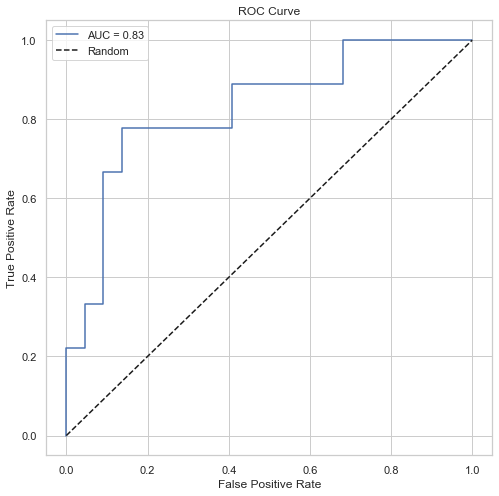

In [83]:
y_probabilities = model.predict_proba(X_test)[:, 1]

auc = roc_auc_score(y_test, y_probabilities)

fpr, tpr, thresholds = roc_curve(y_test, y_probabilities)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

---

# Compare multiple methods

In [84]:
classifiers = {
    'Logistic Regression': LogisticRegression(),
    'Naive Bayes': GaussianNB(),
    'Support Vector Machine': SVC(probability=True),
    'Bagging Decision Tree': BaggingClassifier(),
    'Neural Network': MLPClassifier(max_iter=1000),
    'Boosted Decision Tree': AdaBoostClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Voting Classification': VotingClassifier(estimators=[
        ('lr', LogisticRegression()),
        ('nb', GaussianNB()),
        ('svm', SVC(probability=True)),
        ('rf', RandomForestClassifier())
    ], voting='soft')
}

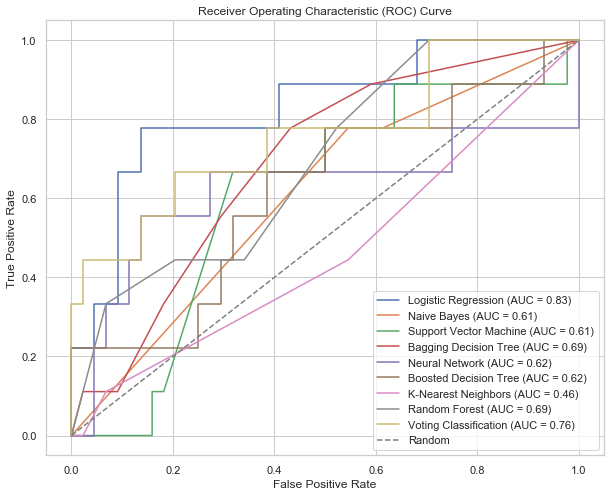

In [85]:
plt.figure(figsize=(10, 8))

for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    
    auc = roc_auc_score(y_test, y_pred_proba)

    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()